In [105]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchsummary
import math
from tqdm import tqdm

In [106]:
%matplotlib inline

In [107]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [108]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )
        
        self.reset_weights()
    
    def forward(self, input):
        return self.layers(input)
    
    def reset_weights(self):
        for layer in self.layers:
            if layer.__class__.__name__.find("Conv") != -1:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif layer.__class__.__name__.find("BatchNorm") != -1:
                nn.init.normal_(layer.weight.data, 1.0, 0.02)
                nn.init.constant_(layer.bias.data, 0)
    
torchsummary.summary(Discriminator(), [3, 64, 64])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         524,288
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 4, 4]       2,097,152
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           8,192
Total params: 2,763,776
Trainable params: 2,763,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.88
Params size (MB): 10.54
Estimated Total Size (MB): 12.46
-------------------------------------

In [109]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(            
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, 0, bias=False),
            nn.Tanh(),
        )
        
        self.reset_weights()
    
    def forward(self, input):
        return self.layers(input)
    
    def reset_weights(self):
        for layer in self.layers:
            if layer.__class__.__name__.find("Conv") != -1:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif layer.__class__.__name__.find("BatchNorm") != -1:
                nn.init.normal_(layer.weight.data, 1.0, 0.02)
                nn.init.constant_(layer.bias.data, 0)
                
torchsummary.summary(Generator(), input_size=[100, 1, 1])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [110]:
import fastai

In [111]:
def set_trainable(mod, is_trainable):
    for param in mod.parameters():
        param.require_grad = is_trainable

In [112]:
import cv2, imutils

In [113]:
import fastai.vision.data as data
from fastai import Path
images_ds = data.ImageClassificationDataset.from_single_folder(Path("/Users/alvaro/Downloads/pokemon/"), classes=[0])

In [114]:
def transform_image(image_tensor):
    image = image_tensor.data.numpy().swapaxes(0, 2)
    image = imutils.resize(image, 64, 64)
    image = (image - 0.5) / 0.5
    return torch.Tensor(image.swapaxes(0, 2))

def collate_fn(images):
    return torch.stack(list(transform_image(i[0].data) for i in images))

batch_size = 16
dl = torch.utils.data.DataLoader(images_ds, batch_size=batch_size, collate_fn=collate_fn)
num_batches = math.ceil(len(images_ds)/batch_size)

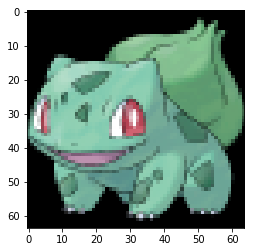

In [115]:
batch = next(iter(dl))
plt.imshow(batch[0].permute(1, 2, 0)*0.5 + 0.5)

In [133]:
discriminator = Discriminator()
generator = Generator()

In [134]:
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0, 0.9))
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0, 0.9))

In [141]:
for images in tqdm(iter(dl), total=num_batches):
# for i in range(20):
    # images = torch.zeros(batch_size, 3, 64, 64)
    noise = torch.randn(len(images), 100, 1, 1)

    set_trainable(discriminator, True)
    set_trainable(generator, False)

    for _ in range(5):
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        images = torch.Tensor(images)
        alpha = torch.randn(batch_size, 1)
        fake_images = generator(noise)
        interpolates = alpha.view(len(images), 1, 1, 1)*images + (1 - alpha.view(len(images), 1, 1, 1))*fake_images
        
        discriminator(interpolates).mean().backward(retain_graph=True)
        grad_penalty = ((torch.cat(list(p.grad.pow(2).view(-1) for p in discriminator.parameters())).mean()).sqrt() - 1).pow(2)
        
        generator.zero_grad()
        discriminator.zero_grad()
        
        loss = (discriminator(images).mean() - discriminator(fake_images).mean()) + 10 * grad_penalty
        loss.backward()
        # with torch.no_grad():
        #     for param in discriminator.parameters():
        #         param.grad.mul_(1)
        
        dis_optimizer.step()

        # for params in discriminator.parameters():
        #     params.data.clamp_(-0.01, 0.01)

    set_trainable(discriminator, False)
    set_trainable(generator, True)

    gen_optimizer.zero_grad()
    dis_optimizer.zero_grad()

    loss = - discriminator(generator(noise)).mean(0)
    loss.backward()
    gen_optimizer.step()


 31%|███       | 16/52 [02:07<04:46,  7.95s/it]

KeyboardInterrupt: 

/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


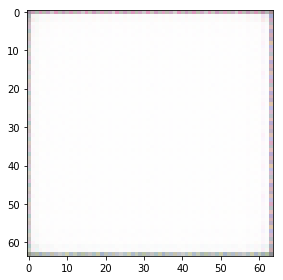

In [140]:
with torch.no_grad():
    fake_img = generator(noise).detach()

fig, plots = plt.subplots(1, 1)
for i, plot in enumerate(np.array(plots).reshape(-1)):
    plot.imshow(fake_img[i].data.numpy().transpose(1, 2, 0)*0.5 + 0.5)
    
#fig.set_figwidth(16)
#fig.set_figheight(5)
fig.tight_layout()
fig.show()

In [131]:
torch.save(generator, "generator.pkl")
torch.save(discriminator, "discriminator.pkl")

/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
